In [2]:
import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

scene = mi.load_file('../scenes/editing-a-scene/cbox.xml')

In [3]:
params = mi.traverse(scene)

key = 'green.reflectance.value'

# Mark the green wall color parameter as differentiable
dr.enable_grad(params[key])

# Propagate this change to the scene internal state
params.update();

In [4]:
image = mi.render(scene, params, spp=128)

In [5]:
# Forward-propagate gradients through the computation graph
dr.forward(params[key])

# Fetch the image gradient values
grad_image = dr.grad(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


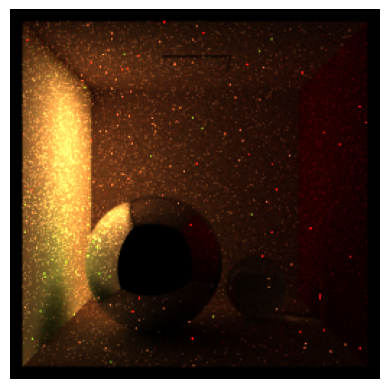

In [6]:
import matplotlib.pyplot as plt
plt.imshow(grad_image * 2.0)
plt.axis('off');

Remapping colors within range: [-2.79, 2.79]


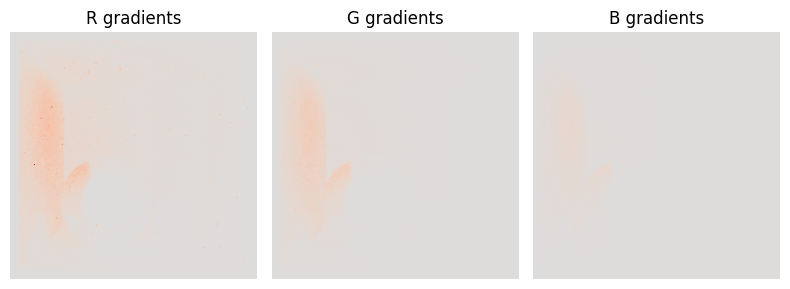

In [7]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

cmap = cm.coolwarm
vlim = dr.max(dr.abs(grad_image))[0]
print(f'Remapping colors within range: [{-vlim:.2f}, {vlim:.2f}]')

fig, axx = plt.subplots(1, 3, figsize=(8, 3))
for i, ax in enumerate(axx):
    ax.imshow(grad_image[..., i], cmap=cm.coolwarm, vmin=-vlim, vmax=vlim)
    ax.set_title('RGB'[i] + ' gradients')
    ax.axis('off')
fig.tight_layout()
plt.show()

In [8]:
# Our latent variable
theta = mi.Float(0.5)
dr.enable_grad(theta)

# The wall color now depends on `theta`
params[key] = mi.Color3f(
    0.2 * theta,
    0.5 * theta,
    0.8 * theta
)

# Propagate this change to the scene internal state
params.update();

In [9]:
dr.forward(theta, dr.ADFlag.ClearEdges)

In [10]:
image = mi.render(scene, params, spp=128)

# Forward-propagate the gradients to the image
dr.forward_to(image)

# Visualize the gradient image
mi.Bitmap(dr.grad(image))

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]